<a href="https://colab.research.google.com/github/agaldran/uqinmia-miccai-2023/blob/main/part2_uncertainty/mcdp_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertainty Quantification in Medical Image Analysis (UQinMIA @ MICCAI 2023)

## *Hands-on*: **Classification:** 2D retina image classification - [MedMIST dataset](https://medmnist.com)
### *Led by Nataliia Molchanova and Vatsal Raina*

# Introduction

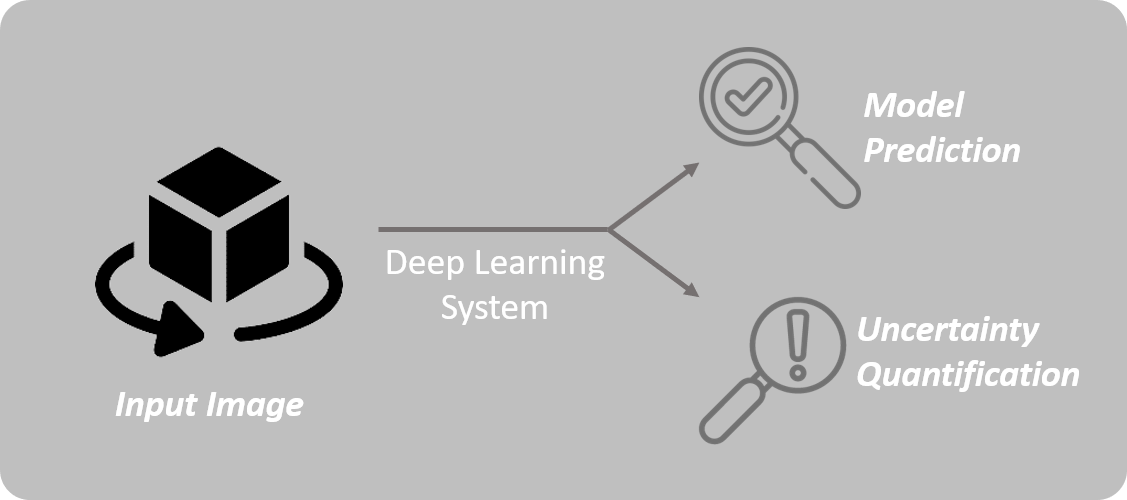



## Setup

In Colab use the GPU: Runtime -> Change runtime type -> Select the GPU option

In [1]:
# install necessery libraries
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import medmnist" || pip install medmnist
!python -c "import seaborn" || pip install -q seaborn
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
# import libraties
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from monai.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary
from medmnist import RetinaMNIST
from medmnist.utils import montage2d
from tqdm import tqdm
import random

# set random seed
seed_value = 0
np.random.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)
  torch.backends.cudnn.deterministic = True
g = torch.Generator()
g.manual_seed(0)

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## I. Task description

We consider a simple image classification task of retina images.

**Classes:** 5 classes from ordinary regression task

**Images shape:** 3 channels x 28 x 28

**Medical imaging modality:** Fundus Camera

**Reference:** DeepDR Diabetic Retinopathy Image Dataset (DeepDRiD), "The 2nd diabetic retinopathy grading and image quality estimation challenge," https://isbi.deepdr.org/data.html, 2020.

Using downloaded and verified file: /home/meri/.medmnist/retinamnist.npz
Using downloaded and verified file: /home/meri/.medmnist/retinamnist.npz
Using downloaded and verified file: /home/meri/.medmnist/retinamnist.npz


`multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.


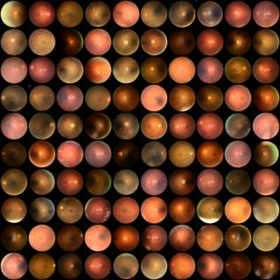

In [2]:
# define transforms
transforms = Compose([
    ToTensor(),
    Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    ])
# load the dataset
train_dataset = RetinaMNIST(
    split='train', transform=transforms, download=True
    )
val_dataset   = RetinaMNIST(
    split='val', transform=transforms, download=True
    )
test_dataset  = RetinaMNIST(
    split='test', transform=transforms, download=True
    )
num_classes = len(np.unique(test_dataset.labels))
# display sample images
test_dataset.montage(length=10)

## II. UQ pipeline for Monte Carlo Dropout (MCDP)

0. Fix the random seed in all the libraries for NN creation and inference.
  
  *E.g.* in MONAI library `monai.utils.set_determinism(42)` or in PyTorch as described [here](https://pytorch.org/docs/stable/notes/randomness.html).
1. Train a model with dropout layers at a chosen dropout probability $α$.

  See more discussion on the choice of dropout layers placement and $\alpha$ [here](https://colab.research.google.com/drive/1E9e3VKQda4aS50hsZm7kschR8IMgsPst#scrollTo=-1bVB1rFGfm_).

2. Given a test example, perform an inference with the dropout switched on.

  Generate a vector of $N$ samples by iteratively inferencing the network and obtaining output softmax probabilities corresponding to different dropout masks.
3. Compute uncertainty.
   
   By quantifying the disagreement / spread of the obtained sample. The easiest is to compute entropy.

### Model training

In [3]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class BayesianResNet(torch.nn.Module):
  """ A ResNet18 implementation with the dropout placed before
  the fully connected layer only.

  The original paper compared this MCDP scheme to placing dropout before
  each convolutional and fully connected layers.
  Code adapted from https://github.com/mlaves/uncertainty-midl/blob/master/models.py
  Original paper: https://arxiv.org/pdf/1908.00792.pdf
  """
  def __init__(self, dropout_prob, num_classes):
      super().__init__()

      # loading a ResNet18 pretrained on ImageNet
      self._resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
      # putting an identity layer instead of the last fully connected layer
      self._resnet.fc = Identity()
      # new fully connected (FC) layer with the needed amount of classes
      self._fc = torch.nn.Linear(in_features=512, out_features=num_classes)
      # dropout layer that will act before the new FC layer
      self._dropout = torch.nn.Dropout(p=dropout_prob)

  def forward(self, x):

      out = self._resnet(x)
      out = self._dropout(out)
      out = self._fc(out)

      return out

In [4]:
# define the model
simple_model = BayesianResNet(0.5, num_classes).to(device)
# print(simple_model)
summary(simple_model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [5]:
def run_one_epoch(loader, model : torch.nn.Module, criterion, optimizer=None):
  """ Inference all data in the loader w.r.t. a specified model.
  Apply backprobagation after each batch inference if needed.
  """
  device='cuda' if next(model.parameters()).is_cuda else 'cpu'
  train = optimizer is not None  # if we are in training mode there will be an optimizer and train=True here

  if train: model.train()
  else: model.eval()
  probs_all, preds_all, labels_all = [], [], []

  for inputs, labels in loader:
      inputs, labels = inputs.to(device), labels.squeeze().to(device)
      logits = model(inputs)
      loss = criterion(logits, labels)

      if train:  # only in training mode
          loss.backward()
          optimizer.step()

      probs = logits.softmax(dim=1).detach().cpu().numpy()
      preds = np.argmax(probs, axis=1)
      labels = labels.cpu().numpy()

      probs_all.extend(probs)
      preds_all.extend(preds)
      labels_all.extend(labels)

  return np.stack(preds_all), np.stack(probs_all), np.stack(labels_all)


In [6]:
# training parameters
lr=1e-3
n_epochs=10

# load the dataset
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=128,
    shuffle=True,
    generator=g
    )
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=256,
    generator=g
    )

# number of classes
num_class = len(np.unique(test_dataset.labels))

# define training actors
optimizer = torch.optim.SGD(
    simple_model.parameters(),
    lr=lr
    )
criterion = torch.nn.CrossEntropyLoss()

# run training
for epoch in tqdm(range(n_epochs)):
  _,  _, _ = run_one_epoch(
      train_loader,
      simple_model,
      criterion,
      optimizer
      )
  with torch.inference_mode():
      tr_preds, tr_probs, tr_labels = run_one_epoch(
          train_loader,
          simple_model,
          criterion
          )
      vl_preds_simple, vl_probs_simple, vl_labels = run_one_epoch(
          val_loader,
          simple_model,
          criterion
          )
      tr_auc = roc_auc_score(
          tr_labels, tr_probs, multi_class='ovr'
          )
      vl_auc = roc_auc_score(
          vl_labels, vl_probs_simple, multi_class='ovr'
          )
      print(
          'Epoch {}, TR/VL AUC={:.2f}/{:.2f}'.format(epoch+1, 100*tr_auc, 100*vl_auc)
          )


# Note that Pytorch is not fully deterministic when GPU is used,
# Thus the results of model training may vary from one run to another
# Use CPU to obtain more stable results

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:08,  1.02it/s]

Epoch 1, TR/VL AUC=59.60/52.05


 20%|██        | 2/10 [00:01<00:04,  1.74it/s]

Epoch 2, TR/VL AUC=74.61/71.44


 30%|███       | 3/10 [00:01<00:03,  2.27it/s]

Epoch 3, TR/VL AUC=79.49/74.77


 40%|████      | 4/10 [00:01<00:02,  2.65it/s]

Epoch 4, TR/VL AUC=79.60/75.49


 50%|█████     | 5/10 [00:02<00:01,  2.91it/s]

Epoch 5, TR/VL AUC=81.09/77.77


 60%|██████    | 6/10 [00:02<00:01,  3.10it/s]

Epoch 6, TR/VL AUC=83.16/77.02


 70%|███████   | 7/10 [00:02<00:00,  3.23it/s]

Epoch 7, TR/VL AUC=84.49/82.05


 80%|████████  | 8/10 [00:02<00:00,  3.32it/s]

Epoch 8, TR/VL AUC=84.79/77.60


 90%|█████████ | 9/10 [00:03<00:00,  3.37it/s]

Epoch 9, TR/VL AUC=86.54/77.40


100%|██████████| 10/10 [00:03<00:00,  2.83it/s]

Epoch 10, TR/VL AUC=87.47/74.79


### Inference

In [40]:
# define the number of mcdp samples
num_mcdp = 10

# use an examples image
idx_test = 113
inputs = test_dataset[idx_test][0].unsqueeze(0).to(device)
labels = test_dataset[idx_test][1]

# enable evaluation regime
simple_model.eval()

# turn on dropout layers despite the evaluation mode
for m in simple_model.modules():
    if m.__class__.__name__.startswith('Dropout'):
      m.train()

# run inference `num_mcdp` times, each time with different dropout mask
with torch.no_grad():
  mcdp_samples = torch.concat([
      simple_model(inputs).softmax(dim=1).detach().cpu()
      for _ in range(num_mcdp)
      ], dim=0
  )

# display the example image
montage2d(test_dataset.imgs, n_channels=3, sel=[idx_test])

### Uncertainty quantification

In [41]:
print("Softmax outputs for each class in each of the samples:")
print(mcdp_samples)
print()
print("Predicted class according to each of the samples:")
print([m.argmax().item() for m in mcdp_samples])
print()
print("Final model prediction will be average across samples softmax probabilities:")
ens_pred_proba = mcdp_samples.mean(dim=0)
print(ens_pred_proba)
print()
print("Final model class prediction argmax of that:")
ens_pred_class = ens_pred_proba.argmax()
print(ens_pred_class)
print()
print("Uncertainty can be quantified as the entropy of the ensemble prediction:")
log_proba = -np.log(ens_pred_proba + 1e-10)
entropy = (ens_pred_proba * log_proba).sum()
print(entropy)

Softmax outputs for each class in each of the samples:
tensor([[0.0646, 0.4534, 0.0326, 0.4297, 0.0197],
        [0.3451, 0.3232, 0.0140, 0.2542, 0.0635],
        [0.1807, 0.1916, 0.0388, 0.4906, 0.0983],
        [0.6124, 0.2838, 0.0165, 0.0502, 0.0370],
        [0.1837, 0.4039, 0.0117, 0.3058, 0.0948],
        [0.4822, 0.1919, 0.0333, 0.2427, 0.0499],
        [0.1218, 0.2594, 0.0594, 0.4673, 0.0921],
        [0.3116, 0.2567, 0.0080, 0.3837, 0.0400],
        [0.1673, 0.4773, 0.0167, 0.2821, 0.0566],
        [0.2080, 0.4841, 0.0120, 0.2650, 0.0309]])

Predicted class according to each of the samples:
[1, 0, 3, 0, 1, 0, 3, 3, 1, 1]

Final model prediction will be average across samples softmax probabilities:
tensor([0.2678, 0.3325, 0.0243, 0.3171, 0.0583])

Final model class prediction argmax of that:
tensor(1)

Uncertainty can be quantified as the entropy of the ensemble prediction:
tensor(1.3391)


### Evaluation of UQ

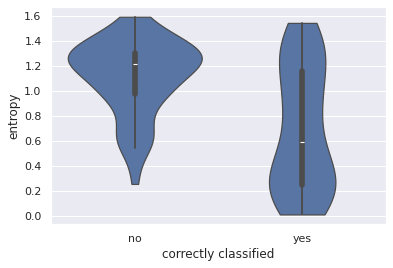

In [42]:
# test examples loader
test_loader = DataLoader(
    dataset=val_dataset,
    batch_size=1
    )

# compute uncertainty for each sample in the test set
data = []

for inputs, labels in test_loader:
  mcdp_samples = torch.concat([
      simple_model(
          inputs.to(device)
          ).softmax(dim=1).detach().cpu()
      for _ in range(num_mcdp)
      ], dim=0
  )

  ens_pred_proba = mcdp_samples.mean(dim=0)

  data_row = {
      'true class': int(labels),
      'predicted class': int(ens_pred_proba.argmax()),
      'entropy': float(-(ens_pred_proba * np.log(ens_pred_proba + 1e-10)).sum())
  }
  data_row['correctly classified'] = 'yes' if data_row['predicted class'] == data_row['true class'] else 'no'

  data.append(data_row)

data = pd.DataFrame(data)

# build a violin plot to diplay the uncertainty distributions of correctly and incorrectly classified samples
sns.violinplot(
    data=data,
    y="entropy",
    x="correctly classified",
    cut=0
    )
plt.show()

## III. Limitations of Monte Carlo Dropout

1. *Computational cost*: Requires several inferences of the model. For the case of large models it might be less practical compared to a single inference uncertainty methods.

2. *Hyperparameter Sensitivity*: The quality of uncertainty estimation using MCDP can be sensitive to the dropout rate, number of samples and dropout layer placement. Finding the right values for these hyperparameters might require additional experimentation. A possible improvement: using a [(spatial) concrete dropout](https://arxiv.org/abs/1705.07832) to make the dropout probabilities trainable parameters.

3. *Model Architecture*: While MCDP works well with many neural network architectures, its effectiveness can vary based on the complexity and structure of the model. Some architectures might not benefit as much from dropout, leading to less accurate uncertainty estimates.

4. *Trade-off Between Uncertainty and Accuracy*: Increasing the number of MCDP samples (repeated predictions with dropout) can improve uncertainty estimation, but it comes at the cost of increased computation time. Finding the right balance between computation time and uncertainty accuracy can be a challenge.

5. *Calibration of  uncertainty*: MCDP model does not necessarilily provide calibrated predictions, thus additional model calibration might be required.

## IV. FAQ

**Choice of the Dropout Probability**

- *Dense layers*: For ANNs consisting of the dense layers, a commonly used dropout probability is 0.5.

- *Convolutional layers*: In ANNs containing convolutional layers, usually lower dropout probabilities are often preferred (e.g., 0.2 to 0.5). Due to weight sharing, putting high dropout rates may lead to fast convergence, preventing from features learning, and thus decreased quality of predictions. In medical image analysis, often even smaller values of dropout are used < 0.2, especially if the dropout is placed before each convolutional layer.

- *Transformer layers*: Transformers tend to require less dropout compared to CNNs or fully connected networks. Analagously to the CNNs, high dropout rates can limit learning capabilities. A dropout probability of 0.1 to 0.3 may be a good starting point.

**Number of Samples**

- There are usually two factors to consider when choosing the number of samples: computational complexity and quality of uncertainty estimates. As there is usually a trade-off between two factors, it is preferable to tune this hyperparameter, for example using the area under an error retention curve as an optimized measure of robustness-uncertainty.